In [11]:
include("../../src/WaterLily.jl")
WaterLily = Main.WaterLily;
using Plots; gr()
using StaticArrays
using JLD
using Images
using FFTW
using Statistics
using Interpolations
using DelimitedFiles
using LinearAlgebra
using PyPlot

In [12]:
N = (32,32)
D = length(N)

2

In [13]:
function sdfTriangle(p, p0, p1, p2)
    e0 = p1-p0
    e1 = p2-p1
    e2 = p0-p2

    v0 = p -p0
    v1 = p -p1
    v2 = p -p2

    pq0 = v0 - e0*clamp( dot(v0,e0)/dot(e0,e0), 0.0, 1.0 )
    pq1 = v1 - e1*clamp( dot(v1,e1)/dot(e1,e1), 0.0, 1.0 )
    pq2 = v2 - e2*clamp( dot(v2,e2)/dot(e2,e2), 0.0, 1.0 )

    s = e0[1]*e2[2] - e0[2]*e2[1];
    d = min.(
        [dot( pq0, pq0 ), s*(v0[1]*e0[2]-v0[2]*e0[1])],
        [dot( pq1, pq1 ), s*(v1[1]*e1[2]-v1[2]*e1[1])],
        [dot( pq2, pq2 ), s*(v2[1]*e2[2]-v2[2]*e2[1])]);

	return -sqrt(d[1])*sign(d[2]);
end

sdfTriangle (generic function with 1 method)

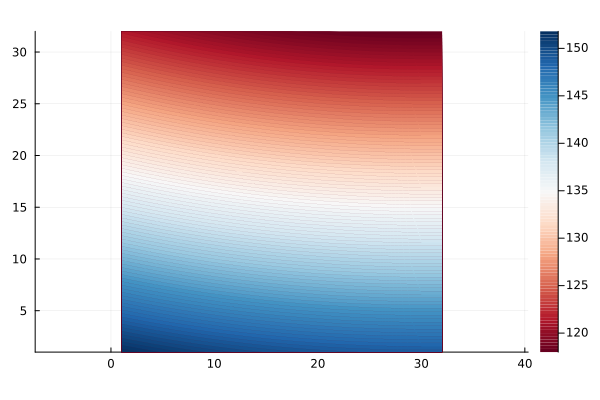

In [14]:

xList = 1:N[1]
yList = 1:N[2]
f = zeros(N)

for i in xList, j in yList
    f[i,j] = sdfTriangle([i,j], [30,150], [30,230], [100,150])
end

Plots.contourf(xList,yList,f',levels=100,linewidth=0,color=:RdBu,aspect_ratio=:equal)
Plots.contour!(xList,yList,f',levels=[0.0],linewidth=2,color=:black,aspect_ratio=:equal)

In [15]:
n̂place, αplace = zeros((N.+2)...,D),zeros(N.+2)
# ins = WaterLily.cVOF(N; InterfaceSDF = (x) -> sqrt.((x[1]-49.5).^2+(x[2]-129.5).^2)-32, perdir=(1,2,3))
ins = WaterLily.cVOF(N,n̂place, αplace; InterfaceSDF = (x) -> 1+x[1])

Main.WaterLily.cVOF{2, Float64, Matrix{Float64}, Array{Float64, 3}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-0.0 -0.0 … -0.0 -0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; -0.0 -0.0 … -0.0 -0.0;;; -0.0 0.0 … 0.0 -0.0; -0.0 0.0 … 0.0 -0.0; … ; -0.0 0.0 … 0.0 -0.0; -0.0 0.0 … 0.0 -0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Int8[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], (0,), (0,), 15.0074, 0.001206)

In [16]:
vertex = [5,20]
leng = 12
for i ∈ vertex[1]:vertex[1]+leng, j ∈ vertex[2]:vertex[2]+leng
    if i-vertex[1] + j-vertex[2] < leng 
        ins.f[i,j] = 1
    elseif i-vertex[1] + j-vertex[2] == leng 
        ins.f[i,j] = 0.5
    end
end

In [17]:
function plotVOF(f)
    Plots.heatmap((1:N[1]+2).-1.5,(1:N[2]+2).-1.5,f',levels=100,linewidth=0,color=:RdBu,aspect_ratio=:equal,clim=(0.0,1.0)) 
    Plots.contour!((1:N[1]+2).-1.5,(1:N[2]+2).-1.5,f',levels=[0.5],linewidth=2,color=:black)
    return Plots.plot!(aspect_ratio=:equal,xlimit=(0,N[1]),ylimit=(0,N[2]),xticks=0:4:N[1],yticks=0:4:N[2])
end

plotVOF (generic function with 1 method)

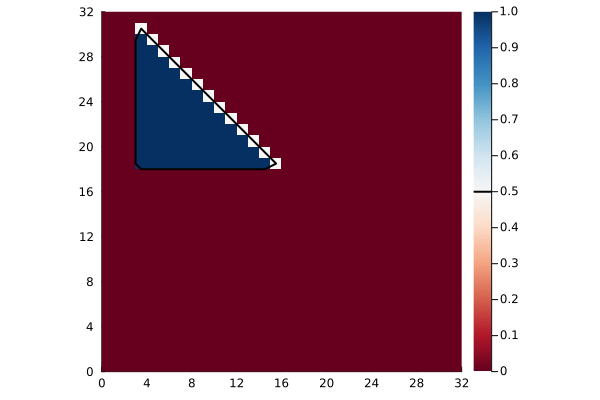

In [18]:
plotVOF(ins.f)

In [19]:
u = zeros((N.+2)...,D)
xList = reshape((1:N[1]+2).-2,(N[1]+2,1,1))
yList = reshape((1:N[2]+2).-2,(1,N[2]+2,1))
u[:,:,1] .= xList/N[1]
u[:,:,2] .= -yList/N[1]
# u[:,:,:,2] .= 1.0
# dt = 0.2
# for i ∈ 1:10
#     WaterLily.freeint_update!(dt, ins.f, ins.f⁰, ins.n̂, ins.α, u, u, ins.ϕᶠ, ins.c̄, perdir=ins.perdir, dirdir=ins.dirdir)
    
# end
# print(Statistics.mean(ins.f[2:end-1,2:end-1,2:end-1]))
# a = 1
# WaterLily.vof_reconstruct!(ins.f,ins.α,ins.n̂)
# WaterLily.vof_flux!(1,ins.f,ins.α,ins.n̂,dt*u,ins.ϕᶠ)
a = 1

1

┌ Info: Saved animation to /tmp/jl_vCfaXo5mjY.gif
└ @ Plots /home/tyhuang/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_vCfaXo5mjY.gif")
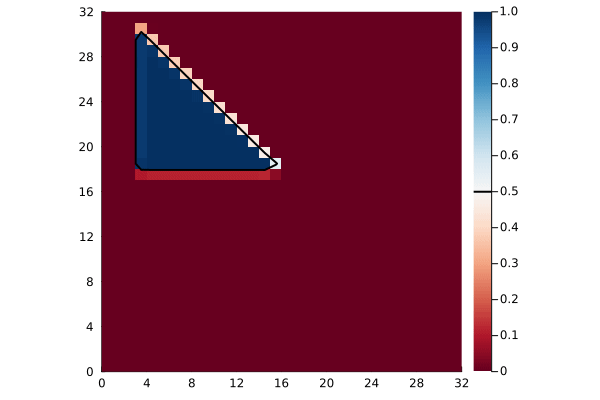

In [20]:
a = Animation()
c = []
n = 1
dt = 0.2/n
u[:,:,1] .= xList/N[1]
u[:,:,2] .= -yList/N[1]
for i ∈ 1:(100*n)
    push!(c,Statistics.mean(ins.f[2:end-1,2:end-1]))
    WaterLily.freeint_update!(dt, ins.f, ins.f⁰, ins.n̂, ins.α, u, u, ins.c̄, perdir=ins.perdir, dirdir=ins.dirdir)
    plt = plotVOF(ins.f)
    if i%n==0
        frame(a,plt)
    end
end
u[:,:,1] .= -xList/N[1]
u[:,:,2] .= yList/N[1]
for i ∈ 1:(100*n)
    push!(c,Statistics.mean(ins.f[2:end-1,2:end-1]))
    WaterLily.freeint_update!(dt, ins.f, ins.f⁰, ins.n̂, ins.α, u, u, ins.c̄, perdir=ins.perdir, dirdir=ins.dirdir)
    plt = plotVOF(ins.f)
    if i%n==0
        frame(a,plt)
    end
end
for i ∈ 1:90
    plt = plotVOF(ins.f)
    frame(a,plt)
end

gif(a)

┌ Info: Saved animation to /tmp/jl_DOXUncrKbq.gif
└ @ Plots /home/tyhuang/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_DOXUncrKbq.gif")
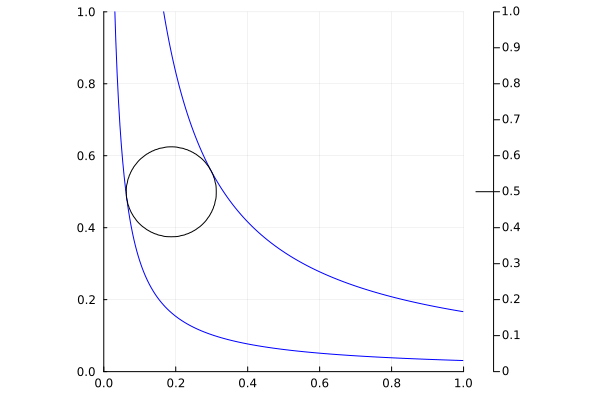

In [5]:
a = Animation()
c = []
dt = 0.2
xy = (θ) -> (0.1875+0.125*cos(θ))*(0.5+0.125*sin(θ))
u[:,:,:,1] .= xList/N[1]
u[:,:,:,2] .= -yList/N[1]
for i ∈ 1:1200
    push!(c,Statistics.mean(ins.f[2:end-1,2:end-1,2:end-1]))
    WaterLily.freeint_update!(dt, ins.f, ins.f⁰, ins.n̂, ins.α, u, u, ins.ϕᶠ, ins.c̄, perdir=ins.perdir, dirdir=ins.dirdir)
    Plots.plot()
    lx = ((1:N[1]).-0.5)/N[1]
    ly = ((1:N[2]).-0.5)/N[2]
    # Plots.heatmap!(lx,ly,ins.f[2:end-1,2:end-1,2]', aspect_ratio=:equal,color=:viridis,levels=6)
    Plots.plot!(lx, xy(3.272265307179586)./lx,legend=false, color=:blue)
    Plots.plot!(lx, xy(6.7728493071795866)./lx,legend=false, color=:blue)
    plt = Plots.contour!(lx,ly,ins.f[2:end-1,2:end-1,2]', aspect_ratio=:equal,color=:Black,levels=[0.5],xlimit=[0,1],ylimit=[0,1])
    if i%10==1
        frame(a,plt)
    end
end
u[:,:,:,1] .= -xList/N[1]
u[:,:,:,2] .= yList/N[1]
for i ∈ 1:1200
    push!(c,Statistics.mean(ins.f[2:end-1,2:end-1,2:end-1]))
    WaterLily.freeint_update!(dt, ins.f, ins.f⁰, ins.n̂, ins.α, u, u, ins.ϕᶠ, ins.c̄, perdir=ins.perdir, dirdir=ins.dirdir)
    Plots.plot()
    lx = ((1:N[1]).-0.5)/N[1]
    ly = ((1:N[2]).-0.5)/N[2]
    # Plots.heatmap!(lx,ly,ins.f[2:end-1,2:end-1,2]', aspect_ratio=:equal,color=:viridis,levels=6)
    Plots.plot!(lx, xy(3.272265307179586)./lx,legend=false, color=:blue)
    Plots.plot!(lx, xy(6.7728493071795866)./lx,legend=false, color=:blue)
    plt = Plots.contour!(lx,ly,ins.f[2:end-1,2:end-1,2]', aspect_ratio=:equal,color=:Black,levels=[0.5],xlimit=[0,1],ylimit=[0,1])
    if i%10==1
        frame(a,plt)
    end
end
gif(a)
# Plots.savefig("afaf.png")

In [6]:
fFinal = copy(ins.f);


In [7]:
sum(abs.(ins.f-fFinal)[2:end-1,2:end-1,2])

0.0

In [8]:
Plots.plot()
# Plots.contour!(lx,ly,fFinal[2:end-1,2:end-1,2]', aspect_ratio=:equal,color=:Black,levels=[0.5],xlimit=[0,1],ylimit=[0,1])
# Plots.contour!(lx,ly,ins.f[2:end-1,2:end-1,2]', aspect_ratio=:equal,color=:Blue,levels=[0.5],xlimit=[0,1],ylimit=[0,1])
Plots.contour!(lx,ly,ins.f[2:end-1,2:end-1,2]'-fFinal[2:end-1,2:end-1,2]', color=:batlow, aspect_ratio=:equal,xlimit=[0.0375, 0.3375],ylimit=[0.35,0.65],clim=(-0.05,0.05),levels=32)
Plots.savefig("cVOF_backerror.png")

UndefVarError: UndefVarError: `lx` not defined

In [9]:
Plots.contour(lx,ly,[1 2],ins.f[2:end-1,2:end-1,2:end-1],levels=[0.5],color=:black)

UndefVarError: UndefVarError: `lx` not defined

In [11]:
Plots.plot((c .-c[1])/c[1])
Plots.savefig("cVOF_masserror.png")

"/home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/cVOF_masserror.png"

In [11]:
ins.f[4:9,4:9,2]

6×6 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [12]:
ins.f[2:end-1,2:end-1,2]'
sqrt.(sum(ins.n̂.^2,dims=[4])[2:end-1,2:end-1,2,1])'
ins.α[2:end-1,2:end-1,2]'

64×64 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                 ⋮              
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.

In [13]:
ins.ϕᶠ[5,5,2,1]

0.0

In [19]:
f = [
    0 0 0 0 0;
    0 0.125 0.5 0.125 0;
    0 0.5 1 0.5 0;
    0 0.125 0.5 0.125 0;
    0 0 0 0 0
]
a = reshape([1 1 1 1],(1,1,4))
f = f.*a;


In [20]:
n̂=zeros(size(f)...,3)
ff=zeros(size(f)...,3)
α = f*0
WaterLily.vof_reconstruct!(f,α,n̂,perdir=(1,2,3))

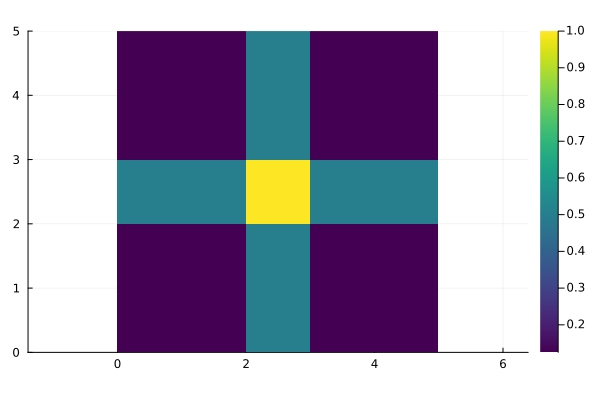

In [23]:
Plots.plot()
lx = (1:5).-0.5
ly = (1:5).-0.5
# Plots.heatmap!(lx,ly,atan.(n̂[:,:,2,2]',n̂[:,:,2,1]')*180/pi, aspect_ratio=:equal,color=:viridis,levels=6)
# Plots.heatmap!(lx,ly,n̂[:,:,2,1]', aspect_ratio=:equal,color=:viridis,levels=6)
Plots.heatmap!(lx,ly,f[:,:,3,1]', aspect_ratio=:equal,color=:viridis,levels=6)

In [4]:
atan.(n̂[:,:,2,2]',n̂[:,:,2,1]')*180/pi

5×5 Matrix{Float64}:
  41.1859   138.814   90.0   41.1859   138.814
 -41.1859  -138.814  -90.0  -41.1859  -138.814
  -0.0     -180.0      0.0   -0.0     -180.0
  41.1859   138.814   90.0   41.1859   138.814
 -41.1859  -138.814  -90.0  -41.1859  -138.814

In [5]:
WaterLily.vof_flux!(1,f,α,n̂,ff*0 .+0.5,ff)

In [6]:
f[:,:,2,1]'

5×5 adjoint(::Matrix{Float64}) with eltype Float64:
 0.125  0.125  0.5  0.125  0.125
 0.125  0.125  0.5  0.125  0.125
 0.5    0.5    1.0  0.5    0.5
 0.125  0.125  0.5  0.125  0.125
 0.125  0.125  0.5  0.125  0.125

In [7]:
ff[:,:,2,1]'

5×5 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0  0.0  0.0    0.0   0.0
 0.0  0.0  0.125  0.25  0.0
 0.0  0.0  0.5    0.5   0.0
 0.0  0.0  0.125  0.25  0.0
 0.0  0.0  0.0    0.0   0.0

In [8]:

using GLMakie


In [9]:
r = LinRange(-1, 1, 100)
cube = [(x.^2 + y.^2 + z.^2) for x = r, y = r, z = r]
GLMakie.contour(ins.f, isorange = 0.05,levels=[0.5])

UndefVarError: UndefVarError: `ins` not defined